In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [40]:
# Load the processed master tracking file
file_path = '../data/processed/master_zone_tracking.csv'
df = pd.read_csv(file_path, low_memory=False)
# Force numeric types for key columns
for c in ['x', 'y', 's', 'dir', 'o', 'ball_land_x', 'ball_land_y']:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors='coerce')

In [42]:
print(df[['s', 'dir', 'o']].isnull().sum())
print("Any missing:", df[['s', 'dir', 'o']].isnull().any().any())

s      0
dir    0
o      0
dtype: int64
Any missing: False


## 1. MIN_POST_THROW_FRAMES Validation (5 frames)

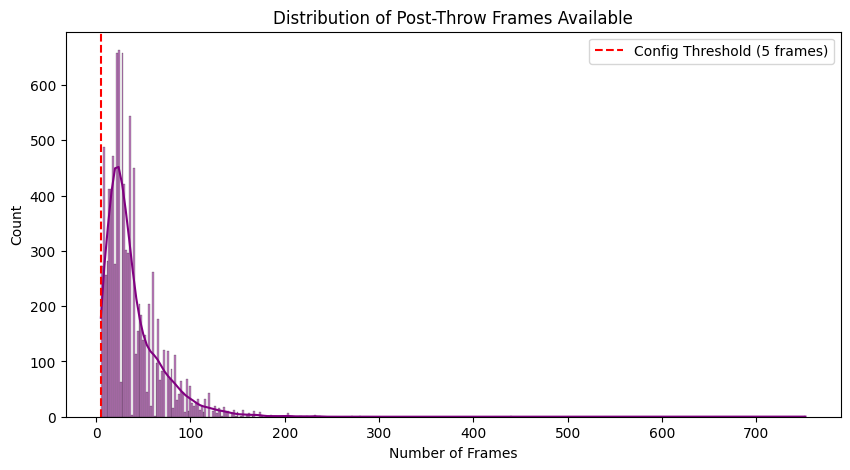

count    10092.000000
mean        38.243857
std         30.482216
min          5.000000
10%         10.000000
25%         18.000000
50%         30.000000
90%         78.000000
max        752.000000
Name: frame_count, dtype: float64


In [43]:
# Timeline analysis: Distribution of post-throw frames
frame_counts = df.groupby(['game_id', 'play_id', 'phase']).size().reset_index(name='frame_count')
post_throw_counts = frame_counts[frame_counts['phase'] == 'post_throw']
plt.figure(figsize=(10, 5))
sns.histplot(post_throw_counts['frame_count'], binwidth=2, kde=True, color='purple')
plt.axvline(x=5, color='r', linestyle='--', label='Config Threshold (5 frames)')
plt.title('Distribution of Post-Throw Frames Available')
plt.xlabel('Number of Frames')
plt.legend()
plt.show()
print(post_throw_counts['frame_count'].describe(percentiles=[0.1, 0.25, 0.5, 0.9]))

## 2. PRE_THROW_WINDOW Validation (15 frames / 1.5s)

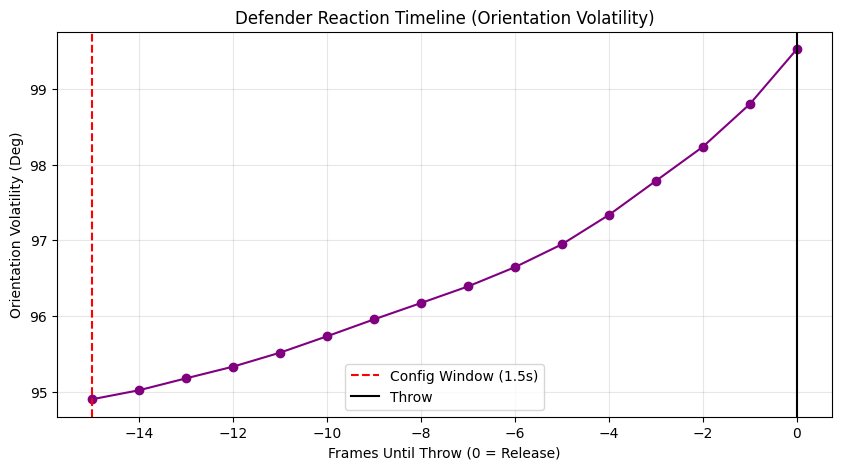

In [44]:
# Pre-throw window volatility validation
pre_throw = df[df['phase'] == 'pre_throw'].copy()
throw_frames = pre_throw.groupby(['game_id', 'play_id'])['frame_id'].max()
pre_throw = pre_throw.merge(throw_frames.rename('throw_frame'), on=['game_id', 'play_id'])
pre_throw['frames_until_throw'] = pre_throw['frame_id'] - pre_throw['throw_frame']
window_df = pre_throw[pre_throw['frames_until_throw'] >= -15]
volatility_profile = window_df.groupby('frames_until_throw')['o'].std()
plt.figure(figsize=(10, 5))
plt.plot(volatility_profile.index, volatility_profile.values, marker='o', color='purple')
plt.axvline(-15, color='r', linestyle='--', label='Config Window (1.5s)')
plt.axvline(0, color='black', linestyle='-', label='Throw')
plt.title('Defender Reaction Timeline (Orientation Volatility)')
plt.xlabel('Frames Until Throw (0 = Release)')
plt.ylabel('Orientation Volatility (Deg)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## 3. COMPETITIVENESS_RADIUS Validation (10 yards)

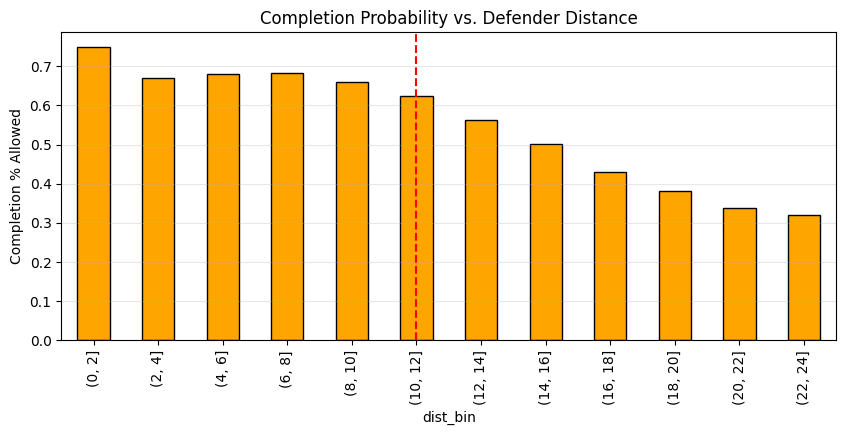

In [45]:
# Completion probability vs. defender distance at throw
starts = df[df['phase'] == 'post_throw'].copy()
if 'ball_land_x' in starts.columns:
    starts['dist_to_ball'] = np.sqrt((starts['x'] - starts['ball_land_x'])**2 + (starts['y'] - starts['ball_land_y'])**2)
    starts['dist_bin'] = pd.cut(starts['dist_to_ball'], bins=range(0, 25, 2))
    comp_rate = starts.groupby('dist_bin', observed=True)['pass_result'].apply(lambda x: (x.astype(str).str.strip()=='C').mean())
    plt.figure(figsize=(10, 4))
    comp_rate.plot(kind='bar', color='orange', edgecolor='black')
    plt.axvline(5, color='r', linestyle='--', label='10.0 Yard Cutoff')
    plt.title('Completion Probability vs. Defender Distance')
    plt.ylabel('Completion % Allowed')
    plt.grid(axis='y', alpha=0.3)
    plt.show()

## 4. PANIC_THRESHOLD Validation (0.5)

Sample Vector Efficiency Scores:
            dir  vector_eff
234  101.738571    0.731999
235  134.274776    0.914882
236  192.339087    0.446382
237  104.743563    0.747092
238  134.292681    0.909852
239  192.200469    0.432975
240  107.969140    0.764411
241  134.325963    0.904203
242  191.309932    0.429961
243  110.820893    0.777328


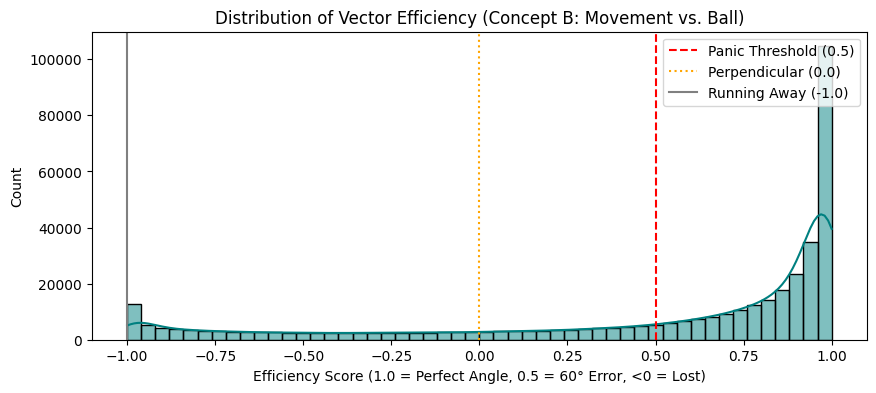

In [64]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Filter for post-throw frames
post_throw = df[df['phase'] == 'post_throw'].copy()

# 2. Construct Ideal Vector (Player -> Ball Landing Spot)
# We assume 'ball_land_x' and 'ball_land_y' are already in the dataframe
post_throw['ideal_x'] = post_throw['ball_land_x'] - post_throw['x']
post_throw['ideal_y'] = post_throw['ball_land_y'] - post_throw['y']

# Normalize Ideal Vector (create unit vector)
post_throw['ideal_mag'] = np.sqrt(post_throw['ideal_x']**2 + post_throw['ideal_y']**2)
post_throw['u_ideal_x'] = post_throw['ideal_x'] / post_throw['ideal_mag']
post_throw['u_ideal_y'] = post_throw['ideal_y'] / post_throw['ideal_mag']

# 3. Construct Movement Unit Vector (from 'dir')
# Convert NFL direction (0=North, Clockwise) to Math radians (0=East, Counter-Clockwise)
# Transformation: Math_Angle = 90 - NFL_Dir
post_throw['dir_rad'] = np.radians(90 - post_throw['dir'])
post_throw['u_move_x'] = np.cos(post_throw['dir_rad'])
post_throw['u_move_y'] = np.sin(post_throw['dir_rad'])

# 4. Calculate Efficiency (Dot Product of Unit Vectors)
# Efficiency = (Move_X * Ideal_X) + (Move_Y * Ideal_Y)
# This gives the Cosine of the angle between the two vectors.
post_throw['vector_eff'] = (post_throw['u_move_x'] * post_throw['u_ideal_x']) + \
                           (post_throw['u_move_y'] * post_throw['u_ideal_y'])

# 5. Visualization
print("Sample Vector Efficiency Scores:")
print(post_throw[['dir', 'vector_eff']].head(10))

plt.figure(figsize=(10, 4))
data_to_plot = post_throw['vector_eff'].dropna()

sns.histplot(data_to_plot, bins=50, kde=True, color='teal')

# Add threshold markers
plt.axvline(0.5, color='r', linestyle='--', label='Panic Threshold (0.5)')
plt.axvline(0.0, color='orange', linestyle=':', label='Perpendicular (0.0)')
plt.axvline(-1.0, color='gray', linestyle='-', label='Running Away (-1.0)')

plt.title('Distribution of Vector Efficiency (Concept B: Movement vs. Ball)')
plt.xlabel('Efficiency Score (1.0 = Perfect Angle, 0.5 = 60° Error, <0 = Lost)')
plt.legend()
plt.show()

## 5. PUPPETEER_ANGLE Validation (60°)

/tmp/ipykernel_61255/2983809489.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  defenders['vision_error'] = np.minimum(diff, 360 - diff)


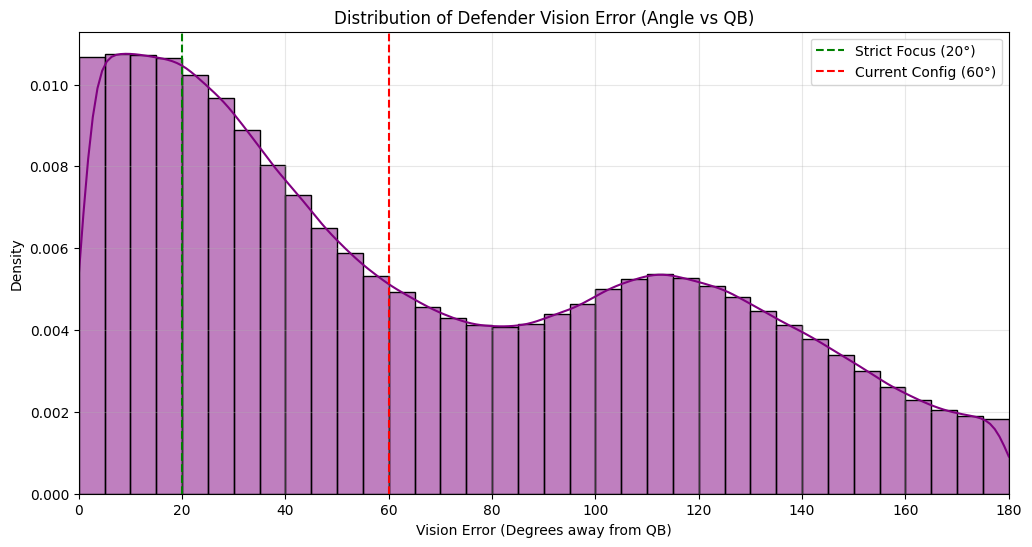

In [98]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def validate_vision_cone(df):
    # 1. Setup Data: Get Pre-Throw window
    pre_df = df[df['phase'] == 'pre_throw'].copy()
    
    # 2. Get QB Location per Frame
    # (Assuming single QB per play, we merge QB coords back onto the df)
    qb_locs = pre_df[pre_df['player_role'] == 'Passer'][['game_id', 'play_id', 'frame_id', 'x', 'y']]
    qb_locs = qb_locs.rename(columns={'x': 'qb_x', 'y': 'qb_y'})
    
    merged = pre_df.merge(qb_locs, on=['game_id', 'play_id', 'frame_id'], how='inner')
    
    # Filter out the QB themselves (they can't look at themselves)
    defenders = merged[merged['player_role'] != 'Passer']
    
    # 3. Calculate Vector to QB
    # Vector form Defender -> QB
    dx = defenders['qb_x'] - defenders['x']
    dy = defenders['qb_y'] - defenders['y']
    
    # Calculate Angle to QB (Math Angle: 0=East, 90=North)
    angle_to_qb_rad = np.arctan2(dy, dx)
    angle_to_qb_deg = np.degrees(angle_to_qb_rad)
    
    # Convert Math Angle to NFL Compass (0=North, 90=East) 
    # Formula: NFL = (90 - Math) % 360
    # Or convert NFL 'o' to Math. Let's convert NFL 'o' to Math to match arctan2
    # NFL 'o' is 0 at North, clockwise. Math is 0 at East, counter-clockwise.
    # Math_Angle = (90 - NFL_O)
    def_o_math = (90 - defenders['o']) 
    
    # 4. Calculate Absolute Difference (The "Vision Error")
    # Smallest difference between two angles
    diff = np.abs(angle_to_qb_deg - def_o_math) % 360
    defenders['vision_error'] = np.minimum(diff, 360 - diff)
    
    # 5. Plotting
    plt.figure(figsize=(12, 6))
    
    # Plot the density of Vision Error
    sns.histplot(defenders['vision_error'], binwidth=5, kde=True, color='purple', stat='density')
    
    plt.title('Distribution of Defender Vision Error (Angle vs QB)')
    plt.xlabel('Vision Error (Degrees away from QB)')
    plt.xlim(0, 180) # Max error is 180 (facing opposite direction)
    
    # Add potential thresholds
    plt.axvline(20, color='green', linestyle='--', label='Strict Focus (20°)')
    plt.axvline(60, color='red', linestyle='--', label='Current Config (60°)')
    
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()

# Run the validation
validate_vision_cone(df)

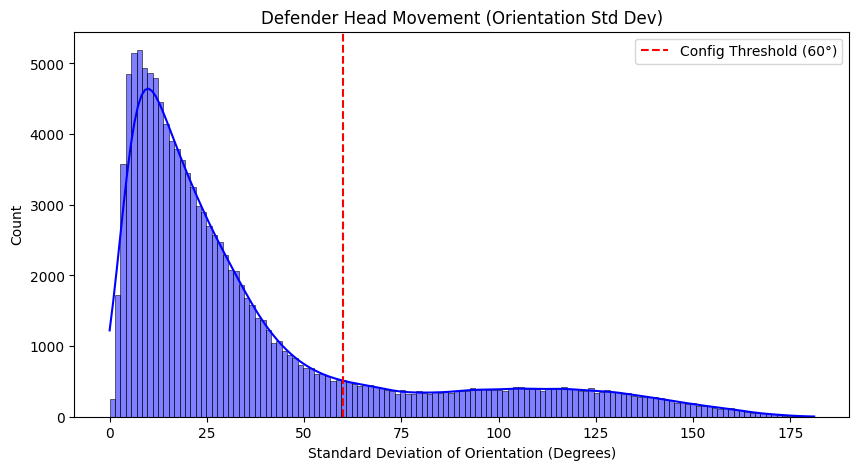

In [66]:
# Defender orientation std dev (vision cone validation)
pre_df = df[df['phase'] == 'pre_throw'].copy()
orientation_std = pre_df.groupby(['game_id', 'play_id', 'nfl_id'])['o'].std().reset_index()
plt.figure(figsize=(10, 5))
sns.histplot(orientation_std['o'], kde=True, color='blue')
plt.title('Defender Head Movement (Orientation Std Dev)')
plt.xlabel('Standard Deviation of Orientation (Degrees)')
plt.axvline(60, color='r', linestyle='--', label='Config Threshold (60°)')
plt.legend()
plt.show()

## 6. DECOY_SPEED Validation (2.5 yds/s)

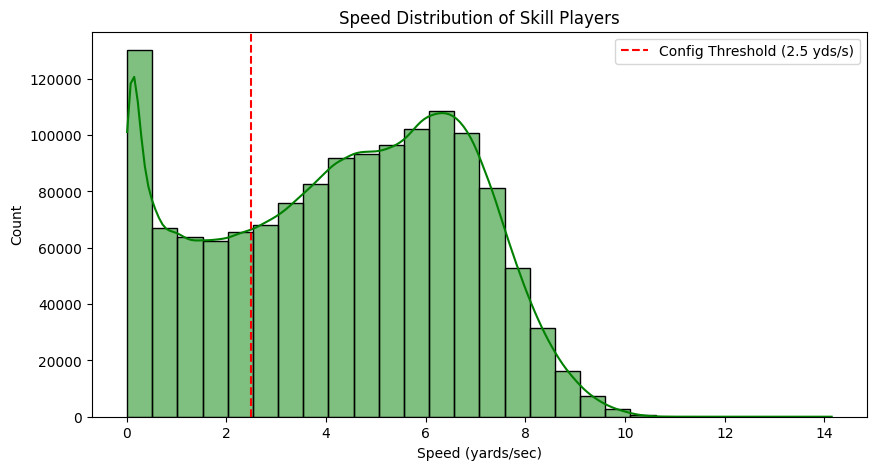

In [97]:
# Speed distribution for skill players
speeds = df[df['player_position'].isin(['WR', 'TE', 'RB', 'FB'])]['s']
plt.figure(figsize=(10, 5))
sns.histplot(speeds, binwidth=0.5, kde=True, color='green')
plt.axvline(x=2.5, color='r', linestyle='--', label='Config Threshold (2.5 yds/s)')
plt.title('Speed Distribution of Skill Players')
plt.xlabel('Speed (yards/sec)')
plt.legend()
plt.show()

## 7. MIN_AIR_YARDS Validation (8.0 yds)

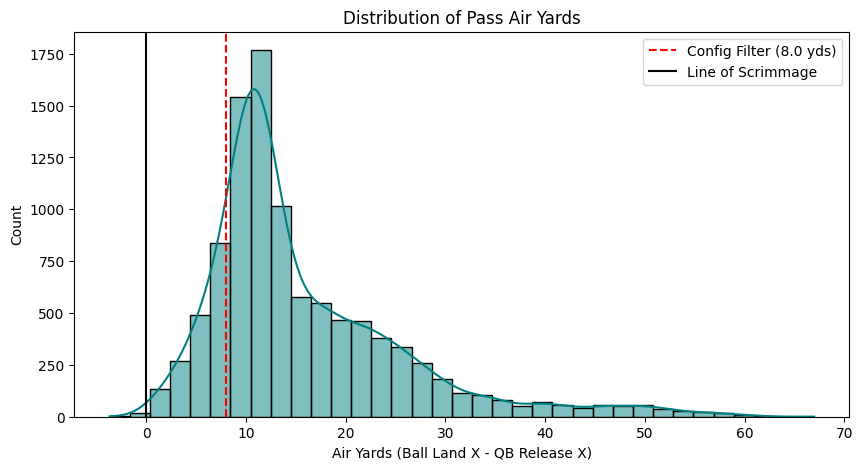

In [49]:
# Air yards distribution and filter
play_summary = df.groupby(['game_id', 'play_id']).agg({'ball_land_x': 'first', 'ball_land_y': 'first'}).reset_index()
throw_frames = df[df['phase'] == 'pre_throw'].groupby(['game_id', 'play_id'])['frame_id'].max().reset_index()
qbs = df[df['player_role'] == 'Passer'].merge(throw_frames, on=['game_id', 'play_id', 'frame_id'])
merged = play_summary.merge(qbs[['game_id', 'play_id', 'x']], on=['game_id', 'play_id'])
merged['air_yards'] = merged['ball_land_x'] - merged['x']
plt.figure(figsize=(10, 5))
sns.histplot(merged['air_yards'], binwidth=2, kde=True, color='teal')
plt.axvline(x=8.0, color='red', linestyle='--', label='Config Filter (8.0 yds)')
plt.axvline(x=0.0, color='black', linestyle='-', label='Line of Scrimmage')
plt.title('Distribution of Pass Air Yards')
plt.xlabel('Air Yards (Ball Land X - QB Release X)')
plt.legend()
plt.show()

## 8. ELITE_CLV Validation (1.5 yds/s)

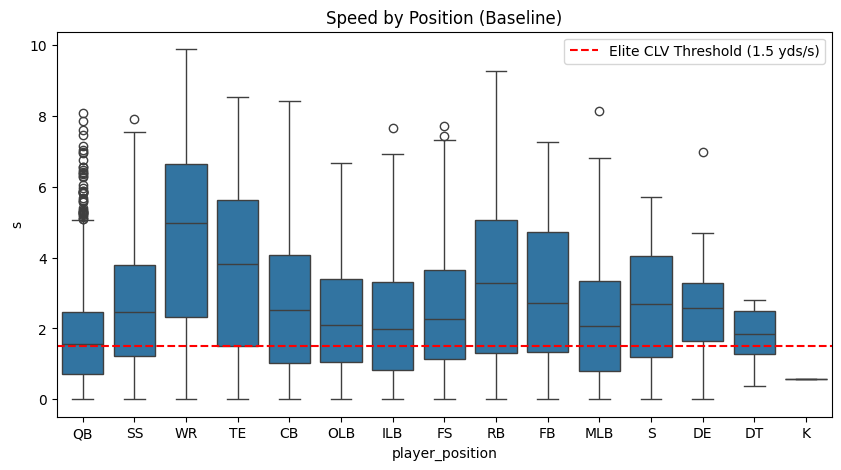

In [50]:
# CLV distribution and elite threshold
sample_df = df[df['phase'] == 'pre_throw'].sample(n=10000, random_state=42) if len(df) > 10000 else df[df['phase'] == 'pre_throw']
plt.figure(figsize=(10, 5))
sns.boxplot(x=sample_df['player_position'], y=sample_df['s'])
plt.title('Speed by Position (Baseline)')
plt.axhline(1.5, color='r', linestyle='--', label='Elite CLV Threshold (1.5 yds/s)')
plt.legend()
plt.show()

## 9. BENCHMARK_SPEED Validation (7.89 yds/s, 90th percentile)

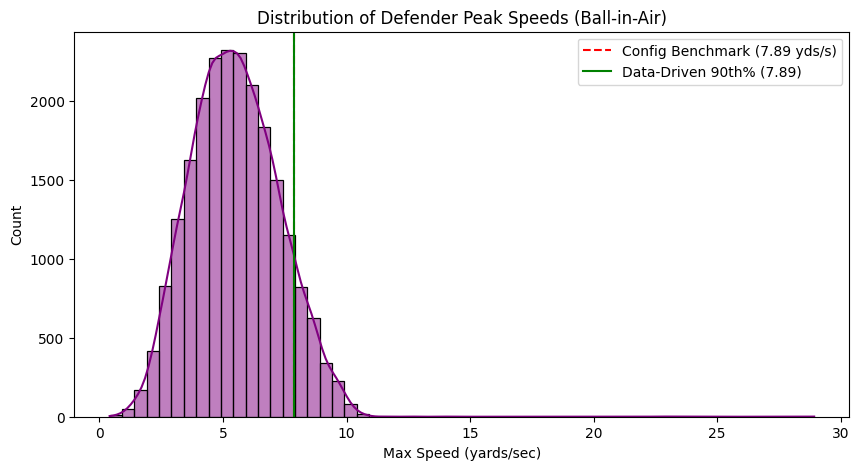

In [51]:
# Defender peak speed benchmark (90th percentile)
pos_col = 'player_position' if 'player_position' in df.columns else 'position'
df[pos_col] = df[pos_col].astype(str).str.strip()
df['phase'] = df['phase'].astype(str).str.strip()
target_positions = ['CB', 'S', 'FS', 'SS', 'LB', 'MLB', 'ILB', 'OLB', 'DB']
chase_df = df[(df['phase'] == 'post_throw') & (df[pos_col].isin(target_positions))].copy()
chase_df = chase_df.sort_values(['game_id', 'play_id', 'nfl_id', 'frame_id'])
chase_df['dx'] = chase_df.groupby(['game_id', 'play_id', 'nfl_id'])['x'].diff()
chase_df['dy'] = chase_df.groupby(['game_id', 'play_id', 'nfl_id'])['y'].diff()
chase_df['calc_s'] = np.sqrt(chase_df['dx']**2 + chase_df['dy']**2) / 0.1
chase_df['s'] = pd.to_numeric(chase_df['s'], errors='coerce')
chase_df['final_s'] = chase_df['s'].fillna(chase_df['calc_s'])
valid_speeds = chase_df.dropna(subset=['final_s'])
max_speeds = valid_speeds.groupby(['game_id', 'play_id', 'nfl_id'])['final_s'].max()
percentiles = max_speeds.quantile([0.5, 0.75, 0.9, 0.95, 0.99])
plt.figure(figsize=(10, 5))
sns.histplot(max_speeds, kde=True, color='purple', binwidth=0.5)
plt.axvline(x=7.89, color='red', linestyle='--', label='Config Benchmark (7.89 yds/s)')
plt.axvline(x=percentiles[0.9], color='green', linestyle='-', label=f'Data-Driven 90th% ({percentiles[0.9]:.2f})')
plt.title('Distribution of Defender Peak Speeds (Ball-in-Air)')
plt.xlabel('Max Speed (yards/sec)')
plt.legend()
plt.show()

In [140]:
import pandas as pd
import statsmodels.api as sm
import numpy as np
file_path = '../src/clv_data_export.csv'
df = pd.read_csv(file_path, low_memory=False)


def run_void_analysis(df):
    print("📊 Running Void Creation Regression...")
    
    # 1. PREPARE DATA
    # Filter for valid pass plays
    reg_df = df[df['pass_result'].isin(['C', 'I', 'IN'])].copy()
    
    # Target: 1 if Complete, 0 if Incomplete/Int
    reg_df['is_complete'] = (reg_df['pass_result'] == 'C').astype(int)
    
    # 2. FEATURE ENGINEERING (Creating the missing columns)
    
    # A. Create Binary Flags from 'leak_cause'
    # Puppeteer: Did the QB freeze them? (Yes=1, No=0)
    # print(len(reg_df))
    # print(len(reg_df[reg_df['leak_cause'] == 'Puppeteer']), "herlloo")
    # print(len(reg_df[reg_df['leak_cause'] == 'Dual Threat']), "herlloo")
    # print(len(reg_df[reg_df['leak_cause'] == 'Gravity']), "herlloo")
    # print(
    #     len(reg_df[(reg_df['leak_cause'] != 'Puppeteer') &
    #                (reg_df['leak_cause'] != 'Dual Threat') &
    #                (reg_df['leak_cause'] != 'Gravity')]),
    #     "hello"
    # )
    reg_df['puppeteer_flag'] = reg_df['leak_cause'].isin(['Puppeteer', 'Dual Threat']).astype(int)
    
    # Gravity: Did a Decoy pull them? (Yes=1, No=0)
    reg_df['gravity_flag'] = reg_df['leak_cause'].isin(['Gravity', 'Dual Threat']).astype(int)
    
    # B. Handle Air Yards (If you haven't re-run the script to add it yet, we impute it for now)
    if 'air_yards' not in reg_df.columns:
        print("⚠️ 'air_yards' missing from CSV. Using mean as placeholder.")
        reg_df['air_yards'] = 10.0 # Placeholder average
    
    # C. Interaction Terms (The "Score")
    # We want to know: Does high CLV matter *more* when it's caused by Puppeteer?
    # Score = Flag * CLV magnitude
    reg_df['puppeteer_impact'] = reg_df['puppeteer_flag'] * reg_df['clv']
    reg_df['gravity_impact'] = reg_df['gravity_flag'] * reg_df['clv']

    # 3. DEFINE REGRESSION
    # We want to predict Completion (Y) using these X variables
    features = ['air_yards', 'puppeteer_impact', 'gravity_impact', 'clv']
    
    X = reg_df[features]
    y = reg_df['is_complete']
    
    # Add constant (intercept)
    X = sm.add_constant(X)
    
    # 4. RUN MODEL
    try:
        model = sm.Logit(y, X).fit()
        print(model.summary())
        
        # 5. INTERPRETATION
        print("\n--- 🏈 RESULTS INTERPRETATION ---")
        
        # Check Puppeteer
        pup_coef = model.params.get('puppeteer_impact', 0)
        pup_pval = model.pvalues.get('puppeteer_impact', 1.0)
        
        if pup_pval < 0.05 and pup_coef > 0:
            print(f"✅ SUCCESS: When QBs fool defenders (Puppeteer), completion chance INCREASES.")
        elif pup_pval < 0.05 and pup_coef < 0:
            print(f"⚠️ INVERTED: Puppeteer plays are resulting in FEWER completions (Check logic).")
        else:
            print(f"❌ NO SIGNAL: Puppeteer moves don't statistically change catch rates.")
            
    except Exception as e:
        print(f"Error: {e}")

# Run it on your dataframe
run_void_analysis(df)

📊 Running Void Creation Regression...
Optimization terminated successfully.
         Current function value: 0.578296
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:            is_complete   No. Observations:                 7397
Model:                          Logit   Df Residuals:                     7392
Method:                           MLE   Df Model:                            4
Date:                Sun, 30 Nov 2025   Pseudo R-squ.:                 0.08673
Time:                        21:57:24   Log-Likelihood:                -4277.7
converged:                       True   LL-Null:                       -4683.9
Covariance Type:            nonrobust   LLR p-value:                1.519e-174
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const                1.5153      0.063     24.076      0.0

In [135]:
4555  + 1671  + 508  + 663  

7397